In [1]:
import sys
import gpytorch
import numpy as np
import pandas as pd
import torch
from datetime import datetime
from scipy.stats import qmc
import itertools
from itertools import combinations_with_replacement, combinations, permutations

import bo_methods_lib
from bo_methods_lib.bo_methods_lib.GPBO_Classes_New import * #Fix this later
from bo_methods_lib.bo_methods_lib.GPBO_Class_fxns import * #Fix this later
from bo_methods_lib.bo_methods_lib.analyze_data import * #Fix this later
from bo_methods_lib.bo_methods_lib.GPBO_Classes_plotters import * #Fix this later
import pympler
import pickle
import signac

from pympler import asizeof

from matplotlib import pyplot as plt

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 200

#Ignore inconcistent version warning
import warnings
# from sklearn.exceptions import InconsistentVersionWarning
# warnings.filterwarnings(action='ignore', category=InconsistentVersionWarning)

/afs/crc.nd.edu/user/m/mcarlozo/.conda/envs/Toy_Problem_env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#From signac
import signac
date_time_str = None
meth_name_str_list = [1, 2, 3, 4, 5]
study_id = "ep"
save_csv = True


criteria_dict = {"cs_name_val" : 8,
                 "param_name_str" : "t1t2t3t4t5",
                 "retrain_GP": 25,
                 "num_x_data": 5,
                 "outputscl": 1,
                 "num_val_pts": 0,
                 "lenscl": None}

df = pd.DataFrame()
job_list = []
for meth_name_val in meth_name_str_list:
    criteria_dict["meth_name_val"] = meth_name_val
    df_piece, jobs, name_cs_str, theta_true = get_study_data_signac(criteria_dict, study_id, save_csv)
    job_list += [job for job in jobs]
#     df_best = get_best_data(df_piece, study_id, name_cs_str, theta_true, param_name_str, date_time_str, save_csv)
    df = pd.concat([df, df_piece], ignore_index=True)
    
# df = df[df['EP Method Val'] == 4]

In [3]:
### Get Best Data from ep experiment
save_csv = True
df_best = get_best_data(df, study_id, name_cs_str, theta_true, job_list, date_time_str, save_csv)
df_best

# df_best["Min Obj Act"].iloc[2]
# save_path = "Results/" + study_id + "_study/" + cs_name + "/" + param_name_str + "/" +  study_id + "_study_best.csv"
# df_best.to_csv(save_path, header = True)
# #Get Mean Data from ep experiment
# df_mean = get_mean_data(df, study_id, name_cs_str, theta_true, param_name_str, date_time_str, save_csv)
# df_mean

# #Get Median Data from ep experiment
# df_median = get_median_data(df, study_id, name_cs_str, theta_true, param_name_str, date_time_str, save_csv)

# #Get Median of Best Data from ep experiment
# df_median_best = get_median_data(df_best, study_id, name_cs_str, theta_true, param_name_str, date_time_str, save_csv)
# df_median_best

,Run Number,BO Iter,Best Error,Exploration Bias,Max EI,Theta Max EI,Min Obj,Min Obj Act,Theta Min Obj,Min Obj Cum.,Theta Min Obj Cum.,Time/Iter,EP Method Val,BO Method,Max Evals,Total Run Time,L2 Norm Theta
7,3,1,334938.115158,1.0,0.0,"[-11.542439498376893, 2.9762260538256378, 14.8...",84245.157344,119059.049179,"[-86.85582704558581, 5.0, 8.772036869865373, 1...",119059.049179,"[-86.85582704558581, 5.0, 8.772036869865373, 1...",0.630617,1,A1,2,1.261233,14.911489
11,0,1,12.721701,1.0,0.0,"[-170.4228893703534, 1.0462201305246834, -8.28...",12.056964,14.308792,"[-98.63253285442131, 5.0, 20.0, 5.0, 20.0]",14.308792,"[-98.63253285442131, 5.0, 20.0, 5.0, 20.0]",0.588876,1,B1,2,1.177751,16.244383
40,0,20,3.563862,1.0,10.690141,"[-169.0061865632325, 4.603603301572512, -10.13...",0.144564,1.41497,"[-99.95783092345332, -1.0026867558186943, 9.99...",1.41497,"[-99.95783092345332, -1.0026867558186943, 9.99...",766.623359,1,A2,22,16865.713902,0.044546
235,1,41,12.721701,1.0,318.042527,"[-142.70688131959972, 1.9545132246389656, 15.4...",3.734012,6.188992,"[-100.6245490058642, -0.8359100753672997, 9.92...",6.188992,"[-100.6245490058642, -0.8359100753672997, 9.92...",2393.11475,1,B2,44,105297.048996,0.729843
307,1,1,334938.115158,1.0,0.0,"[-273.99596357026104, -4.239764447173057, -17....",1196.463367,44533.092977,"[-97.91289792481027, -1.184784586493091, 7.755...",44533.092977,"[-97.91289792481027, -1.184784586493091, 7.755...",199.268388,1,C2,2,398.536777,3.703766


In [4]:
#Get only the jobs which are the best
project = signac.get_project()
job_list_best = []
for meth_name_val in meth_name_str_list:
    #Get best ep data from previous results if possible    
    criteria_dict_ep = criteria_dict.copy()
    criteria_dict_ep["meth_name_val"] = meth_name_val
    criteria_dict_ep["sep_fact"] = 1.0
    meth_name = Method_name_enum(meth_name_val).name
    
    path_name = job_list[0].fn(study_id + "_study_best_all.csv")
    df_ep_best = pd.read_csv(path_name, header = 0)
    best_ep_enum_val = int(df_ep_best["EP Method Val"][(df_ep_best['BO Method'] == meth_name)])
    criteria_dict_ep["ep_enum_val"] = best_ep_enum_val
    
    #Get all jobs with that ep enum val
    jobs_best = project.find_jobs(criteria_dict_ep)
    job_list_best += [job for job in jobs_best]

for i in range(len(job_list_best)): 
    print(job_list_best[i].id)

543e57ef6201cae3da2a9a241e142487
8c22171e626b59ef89c5f4f33bf2c4ce
5cf59d3e12160477aa668a63452455bd
338c7f96179ddd7ad577e01b8c143053
787db7c6c83bb0bee4c066284bb5c7d5


In [ ]:
#Make heat maps
title_fontsize = 24
other_fontsize = 20
xbins = 4
ybins = 5
zbins = 900
save_fig = False
cmap = "autumn"
log_data = True

#Get Best Data from ep experiment
df_best_path = job_list_best[0].fn("ep_study_best_all.csv")
df_best = pd.read_csv(df_best_path, header = 0, index_col = 0)

run_num_list = list(map(int, df_best["Run Number"].to_numpy() + 1))
bo_iter_list = list(map(int, df_best["BO Iter"].to_numpy() + 1))
meth_names = list(df_best["BO Method"])

for i in range(len(job_list_best)):    
    run_num = run_num_list[i]
    bo_iter = bo_iter_list[i]
    file_path = job_list_best[i].fn("BO_Results.gz")
    string_val = df_best["Theta Min Obj"].iloc[0]
    numbers = [float(num) for num in string_val.replace('[', '').replace(']', '').split()]
    dim_theta = np.array(numbers).reshape(-1, 1)
    dim_theta = len(dim_theta)
    dim_list = np.linspace(0, dim_theta-1, dim_theta)
    pairs = len((list(combinations(dim_list, 2))))
    pair = 0
    
    get_ei = False
    analysis_list = analyze_heat_maps(file_path, run_num, bo_iter, pair, log_data, get_ei)
    sim_sse_var_ei, test_mesh, theta_true, theta_opt, theta_next, train_theta, plot_axis_names, idcs_to_plot = analysis_list
    sse_sim, sse_mean, sse_var, ei = sim_sse_var_ei

    title = "Heat Map Pair " + "-".join(map(str, plot_axis_names))
    title = None
#     z = [sse_sim, sse_mean, sse_var, ei]
#     z_titles = ["ln(sse_sim)", "ln(sse)", "ln(sse_var)", "log(ei)"]
#     levels = [100,100,100, 100]
    z = [sse_sim, sse_mean]
    z_titles = ["ln(sse_sim)", "ln(sse)"]
    levels = [100,100]
#     z = [sse_mean]
#     z_titles = [meth_names[i] + " log("+ r"$\mathbf{e(\theta)}$" + ")"]
    
    
    save_path = job_list[i].fn("")
    
    if save_fig == False:
        save_path = None

    plot_heat_maps(test_mesh, theta_true, theta_opt, theta_next, train_theta, plot_axis_names, levels, idcs_to_plot, 
                   z, z_titles, xbins, ybins, zbins, title, title_fontsize, other_fontsize, cmap, save_path)

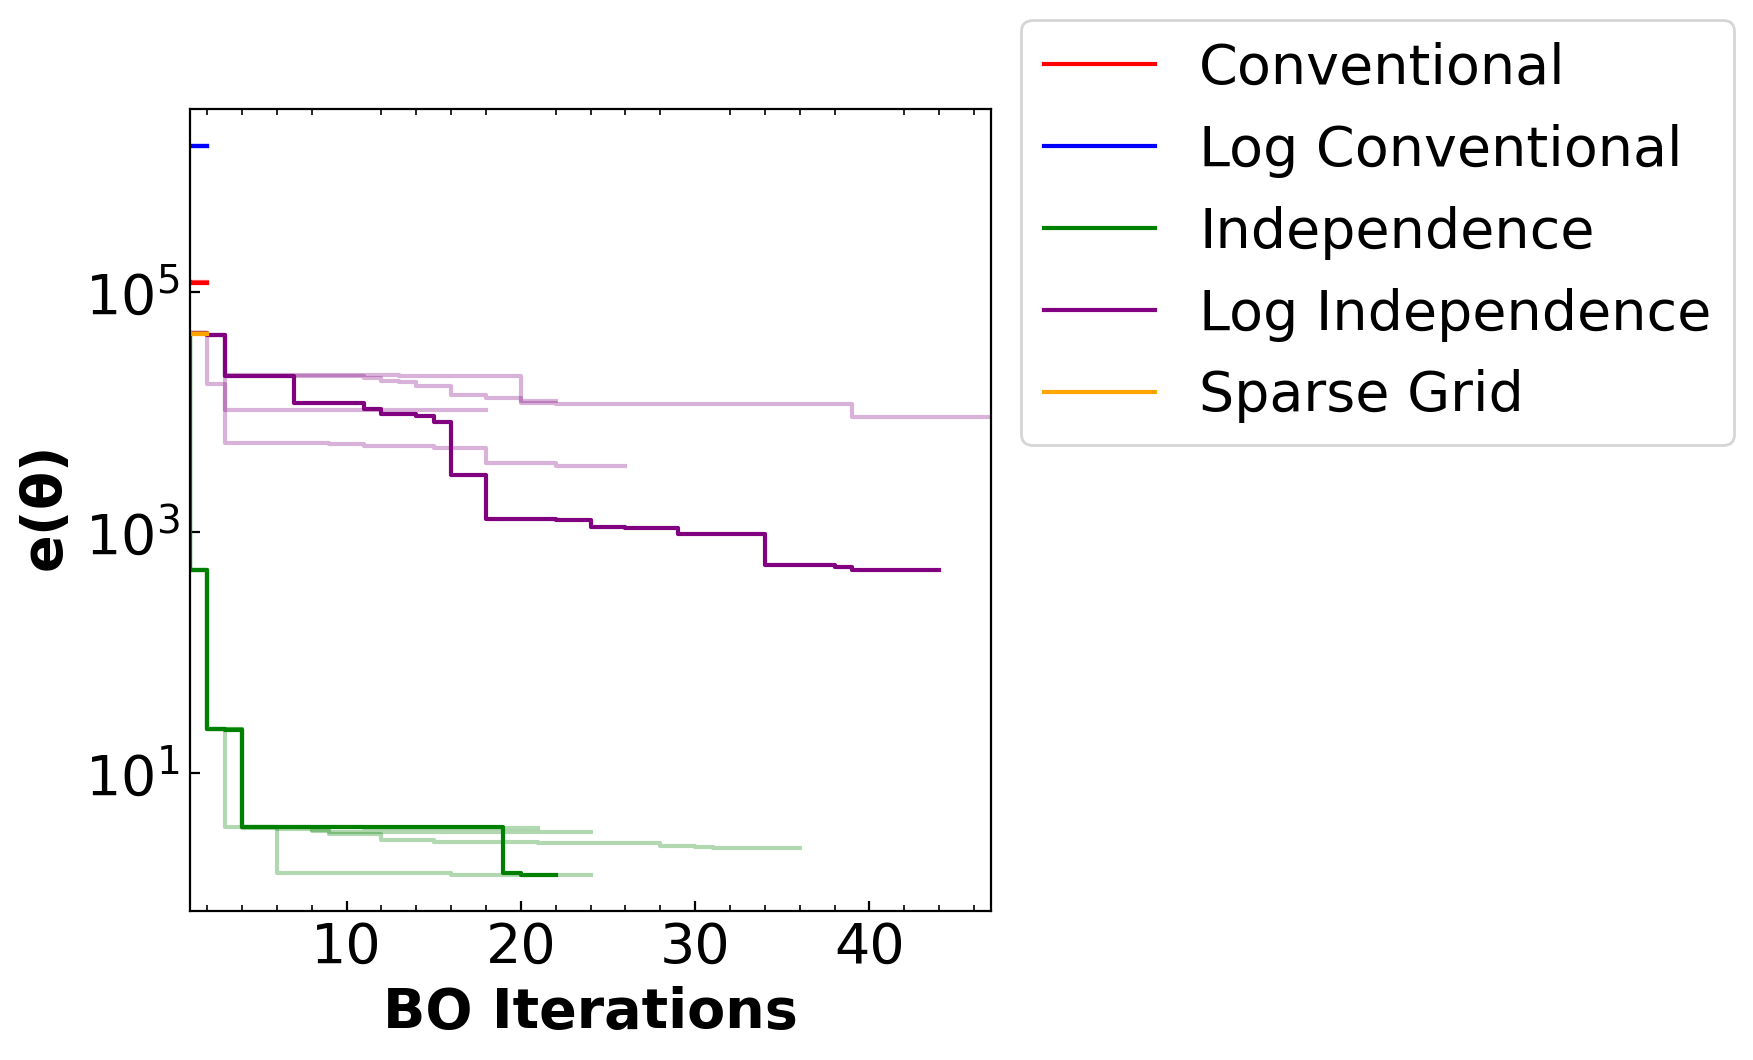

In [5]:
bo_method_list = ["A1", "B1", "A2", "B2", "C2"]
run_num_list = list(map(int, df_best["Run Number"].to_numpy() + 1))
data_names = ["Min SSE"]
string_for_df_theta = ["Min Obj Cum."]
# data_names = ["log(sse)", "min(log(sse))", "log(EI)"]

title_fontsize = 24
other_fontsize = 20
xbins = 5
ybins = 7
x_label = "BO Iterations"
y_label = r"$\mathbf{e(\theta)}$"
# title = "Min SSE Values"
title = None
save_path = None
log_data = False

file_path_list = [job.fn("BO_Results.gz") for job in job_list_best]

plot_method_sse_one_plot(file_path_list, bo_method_list, run_num_list, string_for_df_theta, data_names, xbins, ybins, 
                                   title, x_label, y_label, log_data, title_fontsize, other_fontsize, save_path)

In [8]:
#Plot Muller potential
project = signac.get_project()
meth_name_str_list = [1,2, 3, 4, 5]
for meth_val in meth_name_str_list:
    criteria_dict["meth_name_val"] = meth_val
    jobs = project.find_jobs(criteria_dict) 
    for job in jobs:
        file_path = job.fn("BO_Results.gz")

    loaded_results = open_file_helper(file_path)
    meth_name = Method_name_enum(loaded_results[0].configuration["Method Name Enum Value"]).name


    run_num = df_best.loc[df_best['BO Method'].str.contains(meth_name), 'Run Number'].iloc[0] + 1
    bo_iter = df_best.loc[df_best['BO Method'].str.contains(meth_name), 'BO Iter'].iloc[0] 
    trained_hps = loaded_results[run_num-1].list_gp_emulator_class[bo_iter-1].trained_hyperparams
    print("Method: ", meth_name)
    print("Run Number: ", run_num)
    print("BO Iter Number: ", bo_iter)
    print("Trained Hyperparameters: ", trained_hps)
    x_val_num = 20
    theta_choice = None
    theta_true = loaded_results[run_num-1].simulator_class.theta_true
    theta_choice = theta_true  
#     theta_choice = np.array([-0.12334013, -1.97193209, -9.58736122,  0.70718457]) #(CS2_4 a 2A Set HPs)
#     theta_choice = np.array([-1.25179735, -1.30799798, -6.38989644,  0.69741102]) #(CS2_4 a 2A Trained HPs)   
#     theta_choice = np.array([-1.52838065,  0.76858661, -8.32826196, -0.15766997]) #(CS2_4 a 2C Set HPs)
#     theta_choice = np.array([-0.002612917, 0.493312186, 1.491001765, 0.999614708])  #(CS2_4 y0 2A Trained HPs) 
#     theta_choice = np.array([ 0.9346134,  -0.14312267,  0.65663397, -1.46321351])  #(CS2_4 y0 2C Trained HPs) 

    seed = loaded_results[0].configuration["Seed"]

    title_fontsize = 24
    other_fontsize = 20
    xbins = 4
    ybins = 5
    zbins = 900
    save_path = None
    cmap = "autumn"
    save_path = None

    data_vals = compare_muller_heat_map(file_path, run_num, bo_iter, x_val_num, theta_choice, seed)
    test_mesh, y_sim, gp_mean, gp_var, theta_value, train_X, idcs_to_plot = data_vals
    title = "Heat Map For Theta = " + str(np.round(theta_value,1))

#     z = [y_sim]
#     z_titles = ["y_sim"]
    
    z = [y_sim,  gp_mean, gp_var]
#     print(np.min(y_sim), np.max(y_sim))
    z_titles = ["y_sim" , "y_gp", "y_var"]
    
    cmap = "jet"
    integer = 200
    levels = [integer,integer,integer]
    plot_axis_names = ["X1", "X2"]
#     try:
#         plot_heat_maps(test_mesh, None, None, None, train_X, plot_axis_names, levels, idcs_to_plot, z, 
#                    z_titles, xbins, ybins, zbins, title, title_fontsize, other_fontsize, cmap, save_path)
#     except:
#         pass
# print("Max EI Theta", theta_choice)

Method:  A1
Run Number:  4
BO Iter Number:  1
Trained Hyperparameters:  [array([74.33457332,  9.6696248 , 23.39459775, 10.092459  , 24.23874364]), 0.0001, 1]
Method:  B1
Run Number:  1
BO Iter Number:  1
Trained Hyperparameters:  [array([ 235.40151778, 1000.        ,   51.26243041,   57.67110577,
         54.57174414]), 0.0001, 1]
Method:  A2
Run Number:  1
BO Iter Number:  20
Trained Hyperparameters:  [array([136.3959048 ,  21.510719  ,  26.95836829,  12.89596837,
        25.03344078,   2.81651407,   3.36348426]), 0.0001, 1]
Method:  B2
Run Number:  2
BO Iter Number:  41
Trained Hyperparameters:  [array([143.56214306,  30.21836261,  26.19267236,  13.46472904,
        24.29380092,   2.825417  ,   3.35951281]), 0.0001, 1]
Method:  C2
Run Number:  2
BO Iter Number:  1
Trained Hyperparameters:  [array([133.90190023,  20.35363446,  27.45744722,  12.7006717 ,
        25.4564557 ,   2.81412577,   3.3544711 ]), 0.0001, 1]
